In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pylab as plt 
from scipy.stats import norm
import yfinance as yf 
from itertools import accumulate

In [2]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    benchmark = port_ret['Benchmark']
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D', benchmark = benchmark).transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M',
                                                    benchmark = benchmark).transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino', 'IR'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Active Risk'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}", 'Volatility': "{:.1%}",'Active Risk': "{:.1%}",
              'Sharpe': "{:.1f}",'MAR': "{:.2f}", 'Sortino': "{:.1f}",'IR': "{:.2f}" })
      .set_table_styles(styles)
      .set_properties(**{'color': 'black'}))
    
    return metrics


def port_eval(port, freq = 'D', benchmark = None):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    

    rel_return = port_ret.subtract(benchmark, axis = 0) +1

    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(252),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(252/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(12),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(12/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                float(active_risk.iloc[0]),float(IR.iloc[0])]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'Active Risk',
                         'IR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 




def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [3]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles)
          .set_properties(**{'color': 'black'}))
    
    return corr

## Momentum Backtest

To do
- add volatility
- add fundamental data
- try different things
    - Acceleration
- Use daily data 
- Add rebalancing options, daily, monthly...

In [4]:
price_df = pd.read_csv('data/VQ_data.csv')
price_df['d'] = pd.to_datetime(price_df['d'])
price_df = price_df.set_index(['d', 'insID'])

In [5]:
index_df = pd.read_csv('data/OMX_GI.csv')
index_df['d'] = pd.to_datetime(index_df['d'])
index_df = index_df.set_index(['d'])
index_df = pd.DataFrame(index_df['c'])
index_df = index_df.resample('m').last()
index_df = index_df.pct_change()
index_df = index_df.shift(-1)

### SETTINGS FOR BACKTEST

In [31]:
# USE ONLY DATA WHERE WE HAVE EA RET
close_df = price_df.loc[price_df['PE'].first_valid_index():,]


FREQ = 'Monthly'
top_n = 30
rebal_period = 1
min_MCAP = 500000000
not_secors = ['finance_RE'] #'finance_RE'
not_markets = []

close_df=close_df[ ~close_df['sector'].isin(not_secors)]
close_df=close_df[ ~close_df['market'].isin(not_markets)]
close_df = close_df[close_df['MCAP']<min_MCAP]

In [32]:
## Resample to monthly
if FREQ == 'Monthly':
    data_df =close_df.groupby([close_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
elif FREQ == 'Daily':
    data_df = close_df.copy()

# get return, use adjusted price for dividends
data_df['ret'] = data_df['adj_c'].groupby(level='insID').pct_change(1).shift(-1)



### RANKS

In [33]:
### Momentum Ranks


#rank based on 12 month mom
data_df['mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=False)
data_df['mom6_rank'] = data_df['mom6'].groupby(level='d').rank(ascending=False)
data_df['mom3_rank'] = data_df['mom3'].groupby(level='d').rank(ascending=False)
data_df['ST_rev_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=True)
data_df['adj_mom_rank'] = data_df['adj_mom'].groupby(level='d').rank(ascending=False)
data_df['EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=False)
data_df['EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=False)
data_df['accel_rank'] = data_df['acceleration'].groupby(level='d').rank(ascending=False)
data_df['volatility_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=True)
data_df['sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=True)
data_df['RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=False)
data_df['SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=False)
data_df['EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=False)
data_df['rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=False)
data_df['EPS_a_rank'] = data_df['EPS_acceleration'].groupby(level='d').rank(ascending=False)




### COMPOSITE RANKS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(comb_mom = x.mom12_rank + x.mom6_rank +x.mom3_rank)) #x.mom12_rank + x.mom6_rank +x.mom3_rank +

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_MOM = x.comb_mom +x.EAR_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_std_MOM = x.comb_mom +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(focus_mom = x.EAR_std_rank + x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mom_vol = x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(fund_mom = x.SUE_rank + x.RSURP_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_SUE = x.SUE_rank +x.EAR_std_rank ))

data_df['comb_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mom_vol_rank'] = data_df['mom_vol'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['EAR_SUE_rank'] = data_df['EAR_SUE'].groupby(level='d').rank(ascending=True)  #should be True



data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom = x.fund_mom_rank + x.ear_mom_rank))
data_df['twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom_alt = x.fund_mom_rank + x.comb_mom_rank))
data_df['twin_mom_alt_rank'] = data_df['twin_mom_alt'].groupby(level='d').rank(ascending=True)  #should be True





In [34]:
##VALUATION MEASURES
data_df[data_df['PE']< 0]['PE'] = data_df['PE'].max()
data_df[data_df['PB']< 0]['PB'] = data_df['PB'].max()
data_df[data_df['EVEBIT']< 0]['EVEBIT'] = data_df['EVEBIT'].max()
data_df[data_df['EVFCF']< 0]['EVFCF'] = data_df['EVFCF'].max()
data_df[data_df['PS']< 0]['PS'] = data_df['PS'].max()
data_df[data_df['PFCF']< 0]['PFCF'] = data_df['PFCF'].max()




data_df['ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=True)
data_df['PE_rank'] = data_df['PE'].groupby(level='d').rank(ascending=True) #low is good
data_df['PB_rank'] = data_df['PB'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVEBIT_rank'] = data_df['EVEBIT'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVFCF_rank'] = data_df['EVFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['PS_rank'] = data_df['PS'].groupby(level='d').rank(ascending=True) #low is good
data_df['PFCF_rank'] = data_df['PFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['DIVY_rank'] = data_df['DIV_Y'].groupby(level='d').rank(ascending=False) #high is good



#### VALUE COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.PFCF_rank ))

data_df['VC_rank'] = data_df['VC'].groupby(level='d').rank(ascending=True)  #should be True


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC2 = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.PFCF_rank + x.ag_rank))

data_df['VC2_rank'] = data_df['VC2'].groupby(level='d').rank(ascending=True)  #should be True


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [35]:
### PROFITABILITY MEASURES
data_df['GPA_rank'] = data_df['GPA'].groupby(level='d').rank(ascending=False) #high is good
data_df['GPA_chg_rank'] = data_df['GPA_chg'].groupby(level='d').rank(ascending=False) #high is good

data_df['ROIC_rank'] = data_df['ROIC'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_rank'] = data_df['ROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_chg_rank'] = data_df['ROE_chg'].groupby(level='d').rank(ascending=False) #high is good
data_df['AT_rank'] = data_df['AT'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROA_rank'] = data_df['ROA'].groupby(level='d').rank(ascending=False) #high is good
data_df['FCFROE_rank'] = data_df['FCFROE'].groupby(level='d').rank(ascending=False) #high is good


#### QUALITY COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QC = x.GPA_rank + x.ROIC_rank + x.ROE_rank + x.AT_rank + x.FCFROE_rank))

data_df['QC_rank'] = data_df['QC'].groupby(level='d').rank(ascending=True)  #should be True

In [36]:
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VQ = x.VC_rank + x.QC_rank ))#VQ
data_df['VQ_rank'] = data_df['VQ'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QM = x.GPA_rank + x.ear_mom_rank ))#VQ



### COMPOSITE of COMPOSITE METRCIS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VM = x.VC_rank + x.ear_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VMQ = x.VC_rank + x.QC_rank + x.ear_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(zhang = x.ag_rank + x.GPA_rank))#VMQ


data_df['VMQ_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=True)  #should be True
data_df['VM_rank'] = data_df['VM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=True)  #should be True

In [37]:
### ANTI STRATEGIES
data_df['neg_ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=False)

data_df['bad_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['dog_shit_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=True)
data_df['evil_twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)

data_df['bad_ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=False)  #should be True

### Set up back test

- equal weight
- no capital filter
- for loop for different ranks

In [38]:
values_strats_list = ['ag_rank', 'PE_rank','PB_rank','EVEBIT_rank', 'EVFCF_rank', 'PS_rank', 
               'PFCF_rank','DIVY_rank','VC_rank', 'VC2_rank']


quality_strats_list = ['GPA_rank', 'ROIC_rank', 'ROE_rank', 'AT_rank', 'ROA_rank', 'FCFROE_rank', 'QC_rank']


composite_strats_list = ['QC_rank', 'VC_rank', 'ear_std_mom_rank', 'VM_rank', 'QM_rank','VQ_rank', 'VMQ_rank']

momentum_strats_list = ['mom12_rank', 'mom6_rank', 'mom3_rank', 'EAR_std_rank', 'comb_mom_rank','ear_std_mom_rank']

In [45]:
strat_df = pd.DataFrame()
strats_test = composite_strats_list


for strat in strats_test:
    
    rank_tmp = data_df.unstack(level = 'insID')[strat]
    rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
    ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
    
    rank_df_empt= rank_tmp.copy()
    rank_df_empt[:] = np.nan
    for col in rank_tmp.columns:
        rank_df_empt.loc[::rebal_period,col] = np.where(rank_tmp[::rebal_period][col]<=top_n, 1, 0)
    
    filled_rank_df = rank_df_empt.fillna(method="ffill")
    
    ret_tmp=np.multiply(filled_rank_df,ret_df)
    ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
    ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
    ret_neu_tmp.columns = [strat]

    strat_df = pd.concat([strat_df, ret_neu_tmp],axis = 1, sort=False)

In [46]:
strat_df = strat_df.dropna()
result = pd.concat([strat_df, index_df],axis = 1, sort=False)
result.columns = strat_df.columns.to_list() + ["Benchmark"]
result = result.dropna()
result = result[:-1]

In [47]:
#result['SISU'] = 0.7*result['VMQ_rank'] + 0.3*result['focus_mom_rank']

In [48]:
result_cum = result+1
result_cum = result_cum.cumprod()
result_cum = result_cum.astype('float64')

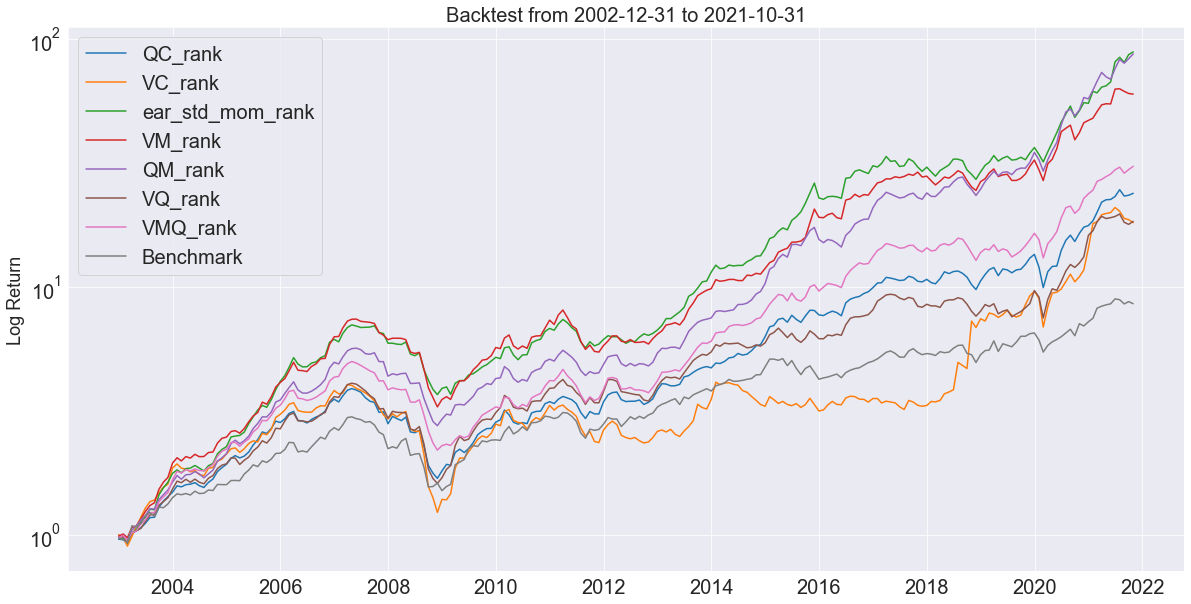

In [49]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result_cum.columns:
    plt.plot(result_cum[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [50]:
data_names = result.columns
strategy_evaluation(result_cum,data_names,freq = 'M')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,Active Risk,IR
QC_rank,18.5%,17.3%,1.1,1.3,-57.0%,0.32,11.8%,0.44
VC_rank,16.6%,25.6%,0.7,1.0,-69.0%,0.24,21.0%,0.17
ear_std_mom_rank,27.0%,18.1%,1.5,2.2,-48.0%,0.56,14.8%,0.84
VM_rank,24.2%,18.9%,1.3,1.7,-56.0%,0.43,14.8%,0.69
QM_rank,26.8%,17.6%,1.5,2.2,-51.0%,0.53,13.4%,0.92
VQ_rank,16.8%,19.2%,0.9,1.2,-61.0%,0.28,13.4%,0.28
VMQ_rank,20.0%,17.0%,1.2,1.5,-56.0%,0.36,12.5%,0.51
Benchmark,12.2%,16.2%,0.8,0.9,-50.0%,0.24,0.0%,0.00


In [20]:
correlation_map(result_cum)

,ag_rank,PE_rank,PB_rank,EVEBIT_rank,EVFCF_rank,PS_rank,PFCF_rank,DIVY_rank,VC_rank,VC2_rank,Benchmark
ag_rank,1.00,0.53,0.35,0.52,0.46,0.36,0.42,0.52,0.38,0.48,0.37
PE_rank,0.53,1.00,0.33,0.76,0.58,0.32,0.57,0.58,0.36,0.36,0.48
PB_rank,0.35,0.33,1.00,0.37,0.30,0.72,0.27,0.36,0.79,0.71,0.34
EVEBIT_rank,0.52,0.76,0.37,1.00,0.56,0.35,0.54,0.55,0.43,0.42,0.49
EVFCF_rank,0.46,0.58,0.30,0.56,1.00,0.33,0.92,0.50,0.38,0.33,0.56
PS_rank,0.36,0.32,0.72,0.35,0.33,1.00,0.32,0.43,0.74,0.78,0.44
PFCF_rank,0.42,0.57,0.27,0.54,0.92,0.32,1.00,0.52,0.31,0.29,0.60
DIVY_rank,0.52,0.58,0.36,0.55,0.50,0.43,0.52,1.00,0.42,0.39,0.62
VC_rank,0.38,0.36,0.79,0.43,0.38,0.74,0.31,0.42,1.00,0.82,0.41
VC2_rank,0.48,0.36,0.71,0.42,0.33,0.78,0.29,0.39,0.82,1.00,0.35


In [21]:
rel_result = result.subtract((pd.Series(result['Benchmark'])), axis = 0)
rel_result = rel_result.drop(['Benchmark'], axis= 1)

In [22]:
Roll_Max = (rel_result+1).cumprod().cummax()
Daily_Drawdown = (rel_result+1).cumprod()/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()
Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)

rel_perf_df = pd.DataFrame( columns = Max_Daily_Drawdown.columns, index=['Max rel. DD','Longest rel. DD'])
rel_perf_df.loc['Max rel. DD',:] = Max_Daily_Drawdown.values


In [23]:
rel_perf_df

,ag_rank,PE_rank,PB_rank,EVEBIT_rank,EVFCF_rank,PS_rank,PFCF_rank,DIVY_rank,VC_rank,VC2_rank
Max rel. DD,-0.67,-0.35,-0.81,-0.74,-0.6,-0.87,-0.64,-0.77,-0.81,-0.67
Longest rel. DD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


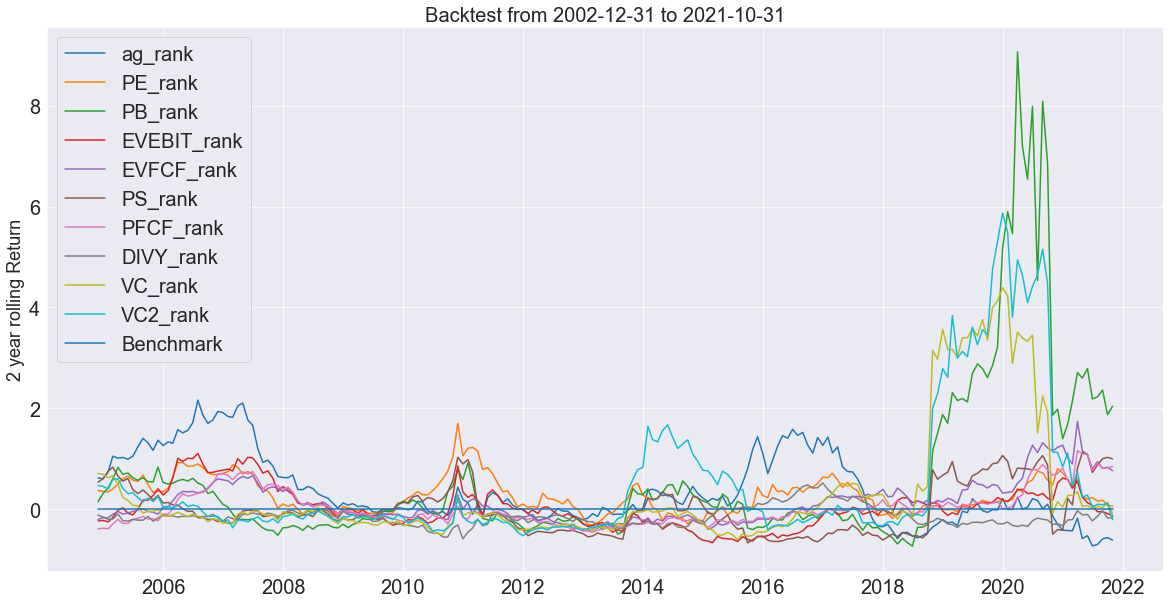

In [24]:
rolling_performance = (1.+result).rolling(window=2*12).agg(lambda x : x.prod()).dropna()
rolling_performance = rolling_performance.subtract(pd.Series(rolling_performance['Benchmark']), axis = 0)



sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in rolling_performance.columns:
    plt.plot(rolling_performance[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.ylabel('2 year rolling Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [25]:
result_by_year = (result+1).groupby(result.index.year).prod() - 1
result_by_month = (result+1).groupby(result.index.month).mean() - 1

In [26]:
result_by_year

,ag_rank,PE_rank,PB_rank,EVEBIT_rank,EVFCF_rank,PS_rank,PFCF_rank,DIVY_rank,VC_rank,VC2_rank,Benchmark
d,,,,,,,,,,,
2002,0.068545,-0.002557,-0.031192,0.010650,-0.033009,-0.023415,-0.037972,0.007292,0.018616,0.051066,-0.031277
2003,0.786677,1.018497,0.572566,0.417869,0.350758,0.767401,0.281420,0.407387,1.153802,0.898372,0.454865
2004,0.257495,-0.011791,0.244821,0.003593,0.094035,0.274590,-0.010174,0.055776,0.084149,0.105702,0.129076
2005,1.206933,0.881750,0.642160,0.789951,0.417391,0.284235,0.431213,0.324809,0.271202,0.405989,0.339885
2006,0.636686,0.281549,0.093557,0.381716,0.608506,0.143763,0.678346,0.105076,0.115613,0.036510,0.267139
2007,0.022542,-0.102158,-0.381661,0.082137,-0.133454,-0.168400,-0.144119,-0.138010,-0.108912,-0.137633,-0.177036
2008,-0.332387,-0.315085,-0.577203,-0.511974,-0.356145,-0.541212,-0.369413,-0.398961,-0.582445,-0.521078,-0.322967
2009,0.654538,0.792653,1.954450,0.645565,0.473270,1.657261,0.343515,0.286951,0.816887,0.935739,0.603420
2010,0.318706,0.697540,-0.128822,0.415153,0.347734,0.085038,0.356644,0.086568,0.023561,-0.053036,0.237346


## Performance by rebalancing date

- measure by sharpe ratio

In [27]:
rebal_diff_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))
turnover_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))


for strat in strats_test:
    
    for rebal in rebal_diff_df.columns:
    
        rank_tmp = data_df.unstack(level = 'insID')[strat]
        rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
        ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
 
        sharpe_list = []    
        rank_df_empt= rank_tmp.copy()
        rank_df_empt[:] = np.nan
        for col in rank_tmp.columns:
            rank_df_empt.loc[::rebal,col] = np.where(rank_tmp[::rebal][col]<=top_n, 1, 0)
    
        filled_rank_df = rank_df_empt.fillna(method="ffill")
    
        ret_tmp=np.multiply(filled_rank_df,ret_df)
        ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
        ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
        ret_neu_tmp.columns = [strat]
        sharpe_tmp = (ret_neu_tmp.mean()*12)/(ret_neu_tmp.std()*np.sqrt(12))
        turnover = filled_rank_df.diff().abs().sum().sum()
        years = len(rank_df_empt)/12
        turn_year = (turnover/top_n)/years
        
        
        turnover_df.loc[strat,rebal] = turn_year/2
        rebal_diff_df.loc[strat,rebal] = sharpe_tmp[0]
        

In [28]:
rebal_diff_df

,1,2,3,4,5,6,7,8,9,10,11,12
ag_rank,0.664316,0.737192,0.738382,0.81166,0.671123,0.796614,0.909086,0.738899,0.559729,0.796097,0.878171,0.815896
PE_rank,0.737026,0.764863,0.642895,0.650737,0.656375,0.605527,0.682587,0.548916,0.714558,0.823246,0.646634,0.575753
PB_rank,0.475849,0.418972,0.370337,0.359533,0.466131,0.402973,0.370454,0.416032,0.472815,0.402007,0.425556,0.55207
EVEBIT_rank,0.335744,0.405308,0.425676,0.378236,0.338321,0.424502,0.432821,0.427302,0.553502,0.622318,0.607503,0.626308
EVFCF_rank,0.643759,0.56467,0.572266,0.565369,0.484116,0.396408,0.520496,0.35479,0.419881,0.539886,0.477031,0.425251
PS_rank,0.334427,0.332805,0.295395,0.272953,0.402141,0.326392,0.325003,0.310403,0.372366,0.405906,0.288197,0.385555
PFCF_rank,0.472188,0.478402,0.400737,0.573867,0.450792,0.467315,0.574134,0.481734,0.471405,0.576919,0.539876,0.620947
DIVY_rank,0.379671,0.420211,0.3545,0.528136,0.483955,0.452426,0.432961,0.431793,0.507642,0.476483,0.45554,0.443816
VC_rank,0.42965,0.480808,0.503191,0.365045,0.385607,0.382664,0.401035,0.329092,0.431187,0.320776,0.317495,0.549698
VC2_rank,0.498867,0.367401,0.391785,0.464596,0.484456,0.388433,0.47826,0.439453,0.420621,0.450125,0.448023,0.381437


In [29]:
turnover_df

,1,2,3,4,5,6,7,8,9,10,11,12
ag_rank,2.259414,1.74728,1.621757,1.506276,1.210042,1.250209,0.989121,1.014226,0.92887,0.833473,0.808368,0.733054
PE_rank,1.865,1.555,1.38,1.285,1.18,1.07,0.99,0.93,0.9,0.84,0.835,0.775
PB_rank,1.75,1.355,1.01,0.915,0.845,0.75,0.715,0.615,0.62,0.555,0.54,0.47
EVEBIT_rank,1.485,1.33,1.185,1.11,0.995,1.01,0.93,0.875,0.845,0.82,0.82,0.735
EVFCF_rank,2.08,1.915,1.605,1.495,1.28,1.22,1.075,1.04,1.015,0.975,0.95,0.885
PS_rank,1.425,1.035,0.785,0.745,0.61,0.595,0.515,0.48,0.47,0.44,0.4,0.395
PFCF_rank,2.39,2.035,1.695,1.51,1.34,1.24,1.1,1.06,1.05,0.98,0.935,0.88
DIVY_rank,1.441048,0.917031,0.775546,0.696943,0.665502,0.5869,0.555459,0.503057,0.508297,0.461135,0.413974,0.455895
VC_rank,1.7625,1.44,1.265,1.085,0.995,0.905,0.935,0.795,0.77,0.725,0.695,0.67
VC2_rank,2.161506,1.629289,1.355649,1.245188,1.074477,1.009205,0.896234,0.858577,0.768201,0.76318,0.702929,0.65272


##  Save returns as pandas dataframe

In [30]:
result.to_csv("data/strategy_returns.csv")